In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations,combinations_with_replacement

import src.utils.helper_functions as helper

In [2]:
current_dir = os.getcwd()
fasta_path = os.path.join(current_dir,"example_data","K562_clean.sample1000.fa.gz")
score_matrix_path = os.path.join(current_dir,"example_data","K562_clean.sample1000.score_matrix.csv.gz")
collisions_path = os.path.join(current_dir,"example_data","K562_clean.sample1000.collisions.pbz2")
recall_path = os.path.join(current_dir,"example_data","K562_clean.sample1000.recall_analysis.csv.gz")
filtered_collisions_path = os.path.join(current_dir,"example_data","K562_clean.sample1000.filtered_collisions.pbz2")

# 0 - Computing all pairwise comparisons

In [88]:
%%time

fasta_dict = helper.parse_fasta_to_dictionary(fasta_path)

n   = len(fasta_dict)
ids = list(fasta_dict)
arr = np.zeros(shape=(n,n),dtype=np.float32)
for i,j in tqdm(combinations_with_replacement(range(n),2)):
    id_i = ids[i]
    id_j = ids[j]
    seq_i = fasta_dict[id_i]
    seq_j = fasta_dict[id_j]
    score = helper.compute_sw_score(seq_i,seq_j)
    arr[i,j] = score
    arr[j,i] = score

df = pd.DataFrame(arr,index=ids,columns=ids)
df.to_csv(score_matrix_path,compression="gzip")
display(df.head(5))
print(df.shape)

500500it [02:39, 3135.38it/s]


,peak10020_Reversed,peak10063_Reversed,peak10125,peak10171_Reversed,peak10246,peak10248,peak10342_Reversed,peak10630,peak10633_Reversed,peak10734_Reversed,...,ENSG00000166473,ENSG00000167536,ENSG00000168118_Reversed,ENSG00000168679_Reversed,ENSG00000169418_Reversed,ENSG00000169682_Reversed,ENSG00000170579,ENSG00000171357_Reversed,ENSG00000171984_Reversed,ENSG00000172115
peak10020_Reversed,200.0,40.0,34.0,44.0,35.0,39.0,40.0,39.0,31.0,47.0,...,39.0,41.0,32.0,43.0,42.0,35.0,33.0,45.0,39.0,43.0
peak10063_Reversed,40.0,200.0,41.0,38.0,47.0,39.0,40.0,38.0,33.0,40.0,...,47.0,32.0,25.0,49.0,35.0,36.0,33.0,31.0,41.0,31.0
peak10125,34.0,41.0,200.0,37.0,45.0,45.0,45.0,39.0,31.0,36.0,...,38.0,31.0,25.0,41.0,30.0,35.0,45.0,25.0,41.0,34.0
peak10171_Reversed,44.0,38.0,37.0,200.0,45.0,37.0,41.0,39.0,33.0,41.0,...,37.0,25.0,28.0,37.0,33.0,33.0,40.0,29.0,42.0,31.0
peak10246,35.0,47.0,45.0,45.0,200.0,44.0,42.0,40.0,35.0,39.0,...,37.0,29.0,28.0,44.0,35.0,33.0,37.0,30.0,35.0,33.0


(1000, 1000)
CPU times: user 2min 44s, sys: 288 ms, total: 2min 44s
Wall time: 2min 44s


# 1 - `lsh_forest`

In [85]:
%%bash

FASTA_PATH=$PWD/example_data/K562_clean.sample1000.fa.gz
OUTPUT_PATH=$PWD/example_data/K562_clean.sample1000.collisions.pbz2

./src/hashFrag lsh_forest -f $FASTA_PATH -k 11 -p 256 -t 256 -n 1000 -s 1 -o $OUTPUT_PATH

LSH Forest process finished and written to: /rshare1/ZETTAI_path_WA_slash_home_KARA/home/brett/work/OrthogonalTrainValSplits/hashFrag/example_data/K562_clean.sample1000.collisions.pbz2


# 2 - `compute_recall`

In [40]:
%%bash

COLLISIONS_PATH=$PWD/example_data/K562_clean.sample1000.collisions.pbz2
SCORE_MATRIX_PATH=$PWD/example_data/K562_clean.sample1000.score_matrix.csv.gz
OUTPUT_PATH=$PWD/example_data/K562_clean.sample1000.recall_analysis.csv.gz

./src/hashFrag compute_recall -c $COLLISIONS_PATH -d $SCORE_MATRIX_PATH -s 1 -o $OUTPUT_PATH

Recall calculation results written to: /rshare1/ZETTAI_path_WA_slash_home_KARA/home/brett/work/OrthogonalTrainValSplits/hashFrag/example_data/K562_clean.sample1000.recall_analysis.csv.gz


In [41]:
recall_df = pd.read_csv(recall_path)
display(recall_df.head(2))
print(recall_df.shape)

,threshold,TP,FP,TN,FN,recall
0,13.0,10896,0,0,989104,0.010896
1,14.0,10896,0,6,989098,0.010896


(188, 6)


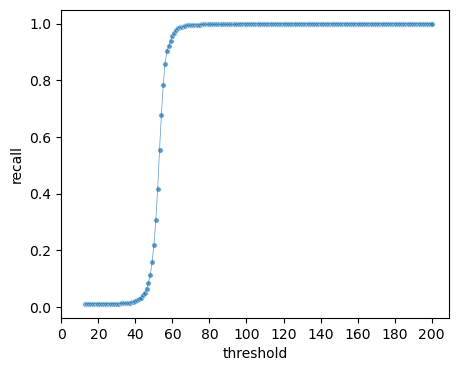

In [59]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
sns.lineplot(results_df,x="threshold",y="recall",ax=ax,alpha=0.75,linewidth=0.5)
sns.scatterplot(results_df,x="threshold",y="recall",ax=ax,alpha=0.75,linewidth=0.5,s=15)
ax.set_xticks(np.arange(0,220,20))
plt.show()

# 3 - `filter_false_positive_collisions`

In [105]:
%%bash

FASTA_PATH=$PWD/example_data/K562_clean.sample1000.fa.gz
COLLISIONS_PATH=$PWD/example_data/K562_clean.sample1000.collisions.pbz2
THRESHOLD=80
OUTPUT_PATH=$PWD/example_data/K562_clean.sample1000.filtered_collisions.pbz2

./src/hashFrag filter_false_positives -f $FASTA_PATH -c $COLLISIONS_PATH -t $THRESHOLD -o $OUTPUT_PATH

Number of pairwise comparisons to compute: 4948
22 sequences remain after filtering according to a threshold of 80
Filtered collision results written to: /rshare1/ZETTAI_path_WA_slash_home_KARA/home/brett/work/OrthogonalTrainValSplits/hashFrag/example_data/K562_clean.sample1000.filtered_collisions.pbz2


# 4 - `create_orthogonal_splits`

In [3]:
filtered_collisions_dict = helper.load_collisions_dictionary(filtered_collisions_path)
len(filtered_collisions_dict)

22

In [4]:
fasta_dict = helper.load_fasta_as_dictionary(fasta_path)
ids = set(fasta_dict)
N = len(ids)
len(fasta_dict)

1000

In [5]:
import random
import igraph as ig
import scipy.sparse as sp
from collections import defaultdict

In [6]:
symmetric_collisions_dict = defaultdict(set)
for query_id,collisions in tqdm(filtered_collisions_dict.items()):
    query_id_ = helper.get_complementary_id(query_id,ids)
    if query_id_ is not None:
        symmetric_collisions_dict[query_id].add(query_id_)
        symmetric_collisions_dict[query_id_].add(query_id)
    for hit_id in collisions:
        symmetric_collisions_dict[query_id].add(hit_id)
        hit_id_ = helper.get_complementary_id(hit_id,ids)
        if hit_id_ is not None:
            symmetric_collisions_dict[query_id].add(hit_id_)
            if query_id_ is not None:
                symmetric_collisions_dict[query_id_].add(hit_id)
                symmetric_collisions_dict[query_id_].add(hit_id_)

print(len(symmetric_collisions_dict))

100%|███████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 197590.34it/s]

22


In [7]:
collision_idset = set()
for query_id,collisions in symmetric_collisions_dict.items():
    collision_idset.add(query_id)
    collision_idset.update(collisions)
collision_ids = list(collision_idset)

In [8]:
n = len(collision_ids)
id_map = { seq_id:i for i,seq_id in enumerate(collision_ids) }
sparse_mat = sp.dok_matrix((n,n),dtype=np.uint8)
for id_i,collisions in tqdm(symmetric_collisions_dict.items()):
    i = id_map[id_i]
    for id_j in collisions:
        j = id_map[id_j]
        sparse_mat[i,j] = 1
        sparse_mat[j,i] = 1
sparse_mat = sparse_mat.tocsr()
sparse_mat

100%|████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 24586.91it/s]


<22x22 sparse matrix of type '<class 'numpy.uint8'>'
	with 52 stored elements in Compressed Sparse Row format>

In [9]:
g = ig.Graph.Weighted_Adjacency(
    matrix=sparse_mat,
    mode="undirected",
    loops=False,
    attr="collisions"
)

In [10]:
components = g.connected_components(mode='weak')
similar_groups = []
for component in components:
    similar_groups.append({ collision_ids[i] for i in component })

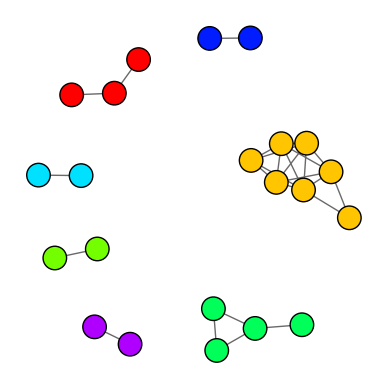

In [11]:
fig, ax = plt.subplots()
ig.plot(
    components,
    target=ax,
    palette=ig.RainbowPalette(),
    vertex_size=0.5,
    vertex_color=list(map(int,ig.rescale(components.membership,(0,200),clamp=True))),
    edge_width=1
)
plt.show()

In [16]:
n_splits = 10
p_train = 0.8
p_test = 0.2

N = len(ids)
train_size = round(p_train*N)
test_size  = round(p_test*N)

train_size,test_size

(800, 200)

In [17]:
for i in tqdm(range(n_splits)):
    split_path = os.path.join(current_dir,"example_data",f"split_{i+1}.csv.gz")
    random.seed(i+1)
    ids_ = list(ids)
    similar_groups_ = similar_groups.copy()

    test_split = set()
    while len(test_split) < test_size and ids_:
        id_x = random.choice(ids_)
        test_split.add(id_x)
        ids_.remove(id_x)

        id_x_ = helper.get_complementary_id(id_x,ids)
        if id_x_ is not None:
            test_split.add(id_x_)
            ids_.remove(id_x_)

        if id_x in collision_idset:
            helper.assert_membership(id_x_,collision_idset)

            for j,group in enumerate(similar_groups_):
                if id_x in group:
                    helper.assert_membership(id_x_,group)
                    group = similar_groups_.pop(j)
                    for id_y in group:
                        if id_x == id_y: continue
                        test_split.add(id_y)
                        ids_.remove(id_y)

                        id_y_ = helper.get_complementary_id(id_y,ids)
                        if id_y_ is not None:
                            helper.assert_membership(id_y_,group)
                            test_split.add(id_y_)
                            ids_.remove(id_y_)

    train_split = set()
    while len(train_split) < train_size and ids_:
        id_x = random.choice(ids_)
        train_split.add(id_x)
        ids_.remove(id_x)

        id_x_ = helper.get_complementary_id(id_x,ids)
        if id_x_ is not None:
            train_split.add(id_x_)
            ids_.remove(id_x_)

        if id_x in collision_idset:
            helper.assert_membership(id_x_,collision_idset)
            for j,group in enumerate(similar_groups_):
                if id_x in group:
                    helper.assert_membership(id_x_,group)
                    group = similar_groups_.pop(j)
                    for id_y in group:
                        if id_x == id_y: continue
                        train_split.add(id_y)
                        ids_.remove(id_y)

                        id_y_ = helper.get_complementary_id(id_y,ids)
                        if id_y_ is not None:
                            helper.assert_membership(id_y_,group)
                            train_split.add(id_y_)
                            ids_.remove(id_y_)

    assert train_split.isdisjoint(test_split)
    helper.write_splits_to_file(train_split,test_split,split_path)


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 127.06it/s]


In [18]:
len(train_split),len(test_split)

(800, 200)